## 四跨连续箱梁桥 OpenSeesPy 建模 Notebook


### 建立 OpenSeesPy 域并设定单位


In [ ]:
import openseespy.opensees as ops
import math
import opsvis as opsv
from dataclasses import dataclass
from itertools import count
from typing import Dict, List, Tuple

PI = math.pi
G = 9.8  # 与 LibUnits.tcl 中的 g 保持一致
UBIG = 1.0e20
CONCRETE_UNIT_WEIGHT = 25_000.0  # N/m3，与 Tcl 模型一致
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)
units = {"length": "m", "force": "N", "mass": "kg"}


## 参数设置


In [22]:


deck_width = 15   #桥面宽度
nodes_per_span = 7 #每跨桥面节点数量


num_spans = 3    #跨数
span_length = 20  #每跨宽度
cols_per_pier = 2  #每墩柱子数量
nodes_per_col = 8  #每柱节点数量
col_height = 8.0   #柱高
edge_clear = 1.5   #桥面挑宽


abut_nodes = 8  #桥台节点数量

# 先定义常量再声明 dataclass，避免引用顺序报错
PI = math.pi
G = 9.8  # 与 LibUnits.tcl 中的 g 保持一致
UBIG = 1.0e20
CONCRETE_UNIT_WEIGHT = 25_000.0  # N/m3，与 Tcl 模型一致

from dataclasses import dataclass
@dataclass
class PierSectionDesign:
    hntbh: float = 30.0
    ps: float = 0.001517
    fyh: float = 2.35e8
    steel_fy: float = 3.35e8
    steel_b: float = 0.01
    diameter: float = 1.5
    cover: float = 0.06
    num_bars: int = 26
    bar_diameter: float = 0.025
    torsion_E: float = UBIG
    nf_core_r: int = 12
    nf_core_t: int = 26
    nf_cover_r: int = 2
    nf_cover_t: int = 26


@dataclass
class CapBeamSectionDesign:
    depth: float = 1.5
    width: float = 1.7
    span_width: float = 8.0
    bearing_offset: float = 0.45
    num_elems: int = 8
    coverH: float = 0.05
    coverB: float = 0.058
    hntbh: float = 30.0
    ps: float = 0.005
    fyh: float = 2.35e8
    steel_fy: float = 3.35e8
    steel_E: float = 2.0e11
    bs: float = 0.01
    r0: float = 18.0
    c1: float = 0.925
    c2: float = 0.15
    num_top: int = 10
    num_bot: int = 10
    num_int_tot: int = 18
    num_center: int = 10
    dia_top: float = 0.025
    dia_bot: float = 0.025
    dia_int: float = 0.012
    dia_center: float = 0.025
    nfY: int = 120
    nfZ: int = 25
    nfYU: int = 2
    nfZU: int = 2


@dataclass
class BearingDesign:
    bkh1: float = 2.1e6
    bkh2: float = 2.1e6
    bkh3: float = 7.85e8
    bfy: float = 72_000.0
    rot_stiff: float = UBIG
    positions: Tuple[float, ...] = (-3.0, -1.0, 1.0, 3.0)


@dataclass
class GirderSectionDesign:
    A: float = 3.536
    E: float = 3.25e10
    nu: float = 0.25
    J: float = 0.092155
    Iy: float = 1.8964
    Iz: float = 18.9088
    mass_per_length: float = 9275.5102


PIER_DESIGN = PierSectionDesign()
CAPBEAM_DESIGN = CapBeamSectionDesign()
BEARING_DESIGN = BearingDesign()
GIRDER_DESIGN = GirderSectionDesign()


### 节点


In [23]:
#桥墩节点
def define_pier_nodes(num_spans: int,
                      span_length: float,
                      cols_per_pier: int,
                      nodes_per_col: int,
                      col_height: float,
                      deck_width: float,
                      edge_clear: float,
                      start_tag: int = 1):
    """
    坐标与几何：
    1) 桥轴线取 x，中间一共 num_spans-1 个桥墩，分别位于
         x_pier = (s+1)*span_length,  s = 0..num_spans-2
    2) 同一桥墩内多根墩柱沿 y 等距布置，左右对称，外侧离桥面边缘保留 edge_clear：
         有效宽度 We = deck_width - 2*edge_clear
         若 cols_per_pier == 1: 仅一根柱，y = 0
         若 cols_per_pier >= 2: y 从 -We/2 到 +We/2 线性分布
    3) 墩柱高 H = col_height。沿 z 从 0 到 H 等分：
         z_k = k * (H/(nodes_per_col-1))，k = 0..nodes_per_col-1。

    参数
    ----
    num_spans     : 跨数（正整数，>=2）
    span_length   : 跨距
    cols_per_pier : 每跨墩柱根数（正整数）
    nodes_per_col : 每根墩柱的节点数（≥2，含顶、底）
    col_height    : 柱高 H
    deck_width    : 桥面总宽度
    edge_clear    : 墩柱外排中心距桥面边缘的横向净距

    返回
    ----
    dict:
      "pier_nodes": [pier][col][level] -> nodeTag
      "coords":     {nodeTag: (x, y, z)}
      "next_tag":   下一个可用节点号
    """
    coords = {}
    pier_nodes = []

    dz = float(col_height) / (nodes_per_col - 1)

    # 计算横向布置
    if cols_per_pier == 1:
        y_list = [0.0]
    else:
        We = float(deck_width) - 2.0 * float(edge_clear)
        if We <= 0.0:
            raise ValueError("deck_width - 2*edge_clear 必须为正，用于布置多根墩柱。")
        dy = We / float(cols_per_pier - 1)
        y_list = [-We / 2.0 + i * dy for i in range(cols_per_pier)]

    # 中间一共 num_spans-1 个桥墩，分别在 x = L, 2L, ..., (num_spans-1)*L
    for s in range(num_spans - 1):
        x = (s + 1) * float(span_length)

        cols = []
        for c in range(cols_per_pier):
            y = y_list[c]

            levels = []
            for k in range(nodes_per_col):
                z = k * dz
                ops.node(start_tag, x, y, z)
                coords[start_tag] = (x, y, z)
                levels.append(start_tag)
                start_tag += 1
            cols.append(levels)
        pier_nodes.append(cols)

    return {"pier_nodes": pier_nodes, "coords": coords, "next_tag": start_tag}


#桥面主梁节点
def define_deck_nodes(num_spans: int,
                      span_length: float,
                      nodes_per_span: int,
                      col_height: float,
                      capbeam_depth: float,
                      bearing_height: float = 0.1,
                      girder_centroid_height: float = 1.24,
                      start_tag = 1000):
    """
    定义桥面（梁）节点；编号从 1000 连续递增。
    布置原则：
      1) 节点位于 y=0，z = col_height + capbeam_depth + bearing_height + girder_centroid_height
         对应TCL: ph1 + CHSec + bh + gxingxinh
      2) 每跨等分为 nodes_per_span 个节点，包含两端点。
      3) 为避免跨间重复，从第二跨起不重复左端点。
    参数
      num_spans              : 跨数（正整数）
      span_length            : 跨距
      nodes_per_span         : 一跨内节点数量（≥2，含两端）
      col_height             : 柱高
      capbeam_depth          : 盖梁高度
      bearing_height         : 支座高度（默认0.1m，对应TCL的bh）
      girder_centroid_height : 主梁形心高度（默认1.24m，对应TCL的gxingxinh）
    返回
      dict:
        "deck_nodes": [span][i] -> nodeTag
        "coords":     {nodeTag: (x, y, z)}
        "next_tag":   下一个可用节点号
    """
    coords = {}
    deck_nodes = []

    dx = float(span_length) / (nodes_per_span - 1)
    # 修正：主梁Z坐标 = 柱高 + 盖梁高度 + 支座高度 + 主梁形心高度
    # 对应TCL代码: ph1 + CHSec + bh + gxingxinh
    z  = float(col_height) + float(capbeam_depth) + float(bearing_height) + float(girder_centroid_height)

    for s in range(num_spans):
        x0 = s * float(span_length)
        span_tags = []
        k_start = 0 if s == 0 else 1  # 避免跨界重复
        for k in range(k_start, nodes_per_span):
            x = x0 + k * dx
            ops.node(start_tag, x, 0.0, z)
            coords[start_tag] = (x, 0.0, z)
            span_tags.append(start_tag)
            start_tag += 1
        deck_nodes.append(span_tags)

    return {"deck_nodes": deck_nodes, "coords": coords, "next_tag": start_tag}

#桥台节点
def define_abutment_nodes(deck_res: list,
                          n: int,
                          total_y: float,
                          start_tag: int = 2000):
    """
    按总长 total_y 与数量 n 在 y 向均匀布置节点。
    返回 {"left": [tags...], "right": [tags...], "next_tag": ...}
    """
    left_node  = deck_res["deck_nodes"][0][0]
    right_node = deck_res["deck_nodes"][-1][-1]
    xL, _, zL = ops.nodeCoord(left_node)
    xR, _, zR = ops.nodeCoord(right_node)

    def _ys(total_len: float, npts: int):
        if npts == 1:
            return [0.0]
        dy = total_len / (npts - 1)
        y0 = -total_len / 2.0
        return [y0 + i * dy for i in range(npts)]

    ys = _ys(float(total_y), int(n))

    left_tags = []
    for y in ys:
        ops.node(start_tag, xL, y, zL)
        left_tags.append(start_tag)
        start_tag += 1

    right_tags = []
    for y in ys:
        ops.node(start_tag, xR, y, zR)
        right_tags.append(start_tag)
        start_tag += 1

    return {"left": left_tags, "right": right_tags, "next_tag": start_tag}

#盖梁节点
def define_capbeam_nodes(pier_nodes, design: CapBeamSectionDesign = CAPBEAM_DESIGN, start_tag=3000):
    """
    参照 Tcl：在每个墩顶沿 y 方向布置一条显式盖梁线。
    """
    tag = int(start_tag)
    capbeam_nodes: List[List[int]] = []

    for pier in pier_nodes:
        top_coords = [ops.nodeCoord(col[-1]) for col in pier]
        x_center = sum(c[0] for c in top_coords) / len(top_coords)
        z_cap = max(c[2] for c in top_coords) + design.depth
        span = design.span_width
        n_seg = design.num_elems
        ys = [-span / 2.0 + i * (span / n_seg) for i in range(n_seg + 1)]

        pier_nodes_list = []
        for y in ys:
            ops.node(tag, x_center, y, z_cap)
            pier_nodes_list.append(tag)
            tag += 1
        capbeam_nodes.append(pier_nodes_list)

    return {"capbeam_nodes": capbeam_nodes, "next_tag": tag}


def init_node_counter(start_tag: int) -> Dict[str, int]:
    return {"value": int(start_tag)}


## 材料与截面定义（对齐 Tcl 框架）

In [24]:
_material_counter = count(1)
_section_counter = count(1)
_integration_counter = count(1)


def next_material_tag() -> int:
    return next(_material_counter)


def next_section_tag() -> int:
    return next(_section_counter)


def next_integration_tag() -> int:
    return next(_integration_counter)


def define_pier_section(design: PierSectionDesign = PIER_DESIGN) -> Dict[str, float]:
    fc = -0.85 * design.hntbh * 1.0e6
    fc1U = fc
    eps1U = -0.002
    fc2U = 0.2 * fc1U
    eps2U = -0.005
    lam = 0.1
    kfc = 1.0 + design.ps * design.fyh / (-fc)
    fc1C = kfc * fc
    eps1C = -0.002 * kfc
    fc2C = 0.2 * fc1C
    eps2C = -(0.004 + 1.4 * design.ps * design.fyh * 0.15 / (-fc1C))
    ftC = -0.07 * fc1C
    ftU = -0.07 * fc1U
    Ets = ftU / 0.002

    mat_core = next_material_tag()
    mat_cover = next_material_tag()
    mat_steel = next_material_tag()
    mat_torsion = next_material_tag()

    ops.uniaxialMaterial('Concrete02', mat_core, fc1C, eps1C, fc2C, eps2C, lam, ftC, Ets)
    ops.uniaxialMaterial('Concrete02', mat_cover, fc1U, eps1U, fc2U, eps2U, lam, ftU, Ets)
    ops.uniaxialMaterial('Hysteretic', mat_steel,
                         design.steel_fy, 0.002, 1.5 * design.steel_fy, 0.15,
                         -design.steel_fy, -0.002, -1.5 * design.steel_fy, -0.15,
                         0.6, 0.6, 0.0, 0.0)
    ops.uniaxialMaterial('Elastic', mat_torsion, design.torsion_E)

    sec_tag = next_section_tag()
    radius = 0.5 * design.diameter
    core_radius = radius - design.cover
    bar_area = 0.25 * math.pi * design.bar_diameter ** 2

    ops.section('Fiber', sec_tag, '-torsion', mat_torsion)
    ops.patch('circ', mat_core, design.nf_core_t, design.nf_core_r, 0.0, 0.0, 0.0, core_radius, 0.0, 360.0)
    ops.patch('circ', mat_cover, design.nf_cover_t, design.nf_cover_r, 0.0, 0.0, core_radius, radius, 0.0, 360.0)
    ops.layer('circ', mat_steel, design.num_bars, bar_area, 0.0, 0.0, core_radius, 0.0, 360.0)

    mass_per_length = (math.pi * design.diameter ** 2 / 4.0) * CONCRETE_UNIT_WEIGHT / G
    return {
        "sec_tag": sec_tag,
        "mass_per_length": mass_per_length,
        "core_mat": mat_core,
        "cover_mat": mat_cover,
        "steel_mat": mat_steel
    }


def define_capbeam_section(design: CapBeamSectionDesign = CAPBEAM_DESIGN) -> Dict[str, float]:
    Cfc = -0.85 * design.hntbh * 1.0e6
    Cfc1U = Cfc
    Ceps1U = -0.002
    Cfc2U = 0.2 * Cfc1U
    Ceps2U = -0.005
    Clambda = 0.1
    CKfc = 1.0 + design.ps * design.fyh / (-Cfc)
    Cfc1C = CKfc * Cfc
    Ceps1C = -0.002 * CKfc
    Cfc2C = 0.2 * Cfc1C
    Ceps2C = -(0.004 + 1.4 * design.ps * design.fyh * 0.15 / (-Cfc1C))
    CftC = -0.07 * Cfc1C
    CftU = -0.07 * Cfc1U
    CEts = CftU / 0.002

    Cmat_core = next_material_tag()
    Cmat_cover = next_material_tag()
    Cmat_steel = next_material_tag()
    Cmat_torsion = next_material_tag()

    ops.uniaxialMaterial('Concrete02', Cmat_core, Cfc1C, Ceps1C, Cfc2C, Ceps2C, Clambda, CftC, CEts)
    ops.uniaxialMaterial('Concrete02', Cmat_cover, Cfc1U, Ceps1U, Cfc2U, Ceps2U, Clambda, CftU, CEts)
    ops.uniaxialMaterial('Steel02', Cmat_steel,
                         design.steel_fy, design.steel_E, design.bs,
                         design.r0, design.c1, design.c2)
    ops.uniaxialMaterial('Elastic', Cmat_torsion, UBIG)

    sec_tag = next_section_tag()
    coverY = design.width / 2.0
    coverZ = design.depth / 2.0
    coreY = coverY - design.coverB
    coreZ = coverZ - design.coverH
    num_int = design.num_int_tot // 2

    ops.section('Fiber', sec_tag, '-torsion', Cmat_torsion)
    ops.patch('quad', Cmat_core, design.nfY, design.nfZ,
              -coreY, -coreZ, coreY, -coreZ, coreY, coreZ, -coreY, coreZ)
    ops.patch('quad', Cmat_cover, design.nfY + 2 * design.nfYU, design.nfZU,
              -coverY, -coverZ, coverY, -coverZ, coverY, -coreZ, -coverY, -coreZ)
    ops.patch('quad', Cmat_cover, design.nfY + 2 * design.nfYU, design.nfZU,
              -coverY, coreZ, coverY, coreZ, coverY, coverZ, -coverY, coverZ)
    ops.patch('quad', Cmat_cover, design.nfYU, design.nfZ,
              -coverY, -coreZ, -coreY, -coreZ, -coreY, coreZ, -coverY, coreZ)
    ops.patch('quad', Cmat_cover, design.nfYU, design.nfZ,
              coreY, -coreZ, coverY, -coreZ, coverY, coreZ, coreY, coreZ)

    area_top = 0.25 * math.pi * design.dia_top ** 2
    area_bot = 0.25 * math.pi * design.dia_bot ** 2
    area_int = 0.25 * math.pi * design.dia_int ** 2
    area_center = 0.25 * math.pi * design.dia_center ** 2

    ops.layer('straight', Cmat_steel, num_int,
              area_int, coreY, -coreZ + 0.14, coreY, coreZ - 0.14)
    ops.layer('straight', Cmat_steel, num_int,
              area_int, -coreY, -coreZ + 0.14, -coreY, coreZ - 0.14)
    ops.layer('straight', Cmat_steel, design.num_top,
              area_top, -coreY, coreZ, coreY, coreZ)
    ops.layer('straight', Cmat_steel, design.num_bot,
              area_bot, -coreY, -coreZ, coreY, -coreZ)
    ops.layer('straight', Cmat_steel, design.num_center,
              area_center, -coreY, -coreZ + 0.039, coreY, -coreZ + 0.039)

    mass_per_length = (design.depth * design.width * CONCRETE_UNIT_WEIGHT) / G
    return {
        "sec_tag": sec_tag,
        "mass_per_length": mass_per_length,
        "steel_mat": Cmat_steel
    }


def define_misc_materials() -> Dict[str, int]:
    soil = next_material_tag()
    deck_abut = next_material_tag()
    shear_key = next_material_tag()
    ops.uniaxialMaterial('ElasticPPGap', soil, 5.0e4, -5000.0, -0.03)
    ops.uniaxialMaterial('ElasticPPGap', deck_abut, 1.0e7, -1.0e8, -0.05)
    ops.uniaxialMaterial('ElasticPPGap', shear_key, 2.0e8, 6.0e5, 0.02)
    return {
        "soil": soil,
        "deck_abut": deck_abut,
        "shear_key": shear_key
    }


## 构建element


In [25]:
def build_pier_elements_nonlin(pier_nodes: list,
                               secTag: int,
                               ele_tag_start: int = 1,
                               np: int = 5,
                               mass_per_length: float | None = None):
    """
    整根墩柱均采用 forceBeamColumn + 纤维截面，模拟 Tcl 版本的建模方式。
    """
    trans_tag = 1
    ops.geomTransf('Linear', trans_tag, 0.0, 1.0, 0.0)
    integ_tag = next_integration_tag()
    ops.beamIntegration('Lobatto', integ_tag, secTag, np)

    eTag = int(ele_tag_start)
    eTags = []

    for pier in pier_nodes:
        for col in pier:
            for i in range(len(col) - 1):
                ni, nj = col[i], col[i + 1]
                args = ['forceBeamColumn', eTag, ni, nj, trans_tag, integ_tag]
                if mass_per_length is not None:
                    args += ['-mass', mass_per_length]
                ops.element(*args)
                eTags.append(eTag)
                eTag += 1

    return eTags



def build_beam_elements_elastic(deck_nodes: list,
                                A: float, E: float, G: float,
                                J: float, Iy: float, Iz: float,
                                ele_tag_start: int = 1000,
                                mass_per_length: float | None = None):
    """
    桥面梁：按中心线顺序连接为 elasticBeamColumn。
    几何变换在函数内定义：Linear，参考向量 (0,0,1)。
    返回：下一个可用元素号。
    """
    # 定义/覆盖几何变换
    trans_tag = 3
    ops.geomTransf('Linear', trans_tag, 0.0, 0.0, 1.0)

    # 串接所有跨的节点（生成时已避免跨界重复端点）
    chain = []
    for span in deck_nodes:
        chain.extend(span)

    eTag = int(ele_tag_start)
    eTags =  []
    for i in range(len(chain) - 1):
        eTags.append(eTag)
        ni, nj = chain[i], chain[i+1]
        args = ['elasticBeamColumn', eTag, ni, nj,
                A, E, G, J, Iy, Iz, trans_tag]
        if mass_per_length is not None:
            args += ['-mass', mass_per_length]
        ops.element(*args)
        eTag += 1
    return eTags


def build_capbeam_elements(capbeam_nodes: List[List[int]],
                           secTag: int,
                           mass_per_length: float,
                           ele_tag_start: int = 4000,
                           np: int = 5):
    """
    显式盖梁建模：forceBeamColumn + RC 纤维截面。
    """
    trans_tag = 4
    ops.geomTransf('Linear', trans_tag, 0.0, 0.0, 1.0)
    integ_tag = next_integration_tag()
    ops.beamIntegration('Lobatto', integ_tag, secTag, np)

    eTag = int(ele_tag_start)
    eTags: List[int] = []
    for pier_nodes in capbeam_nodes:
        for i in range(len(pier_nodes) - 1):
            ni, nj = pier_nodes[i], pier_nodes[i + 1]
            ops.element('forceBeamColumn', eTag, ni, nj, trans_tag, integ_tag,
                        '-mass', mass_per_length)
            eTags.append(eTag)
            eTag += 1
    return eTags


def tie_piers_to_cap_nodes(pier_nodes: List[List[List[int]]],
                           capbeam_nodes: List[List[int]]):
    """
    将每根墩柱顶节点的 6 个自由度约束到最近的盖梁节点，模拟 Tcl 的 equalDOF。
    """
    for pier_group, cap_nodes in zip(pier_nodes, capbeam_nodes):
        cap_coords = {tag: ops.nodeCoord(tag)[1] for tag in cap_nodes}
        for column in pier_group:
            top_node = column[-1]
            y_top = ops.nodeCoord(top_node)[1]
            cap_target = min(cap_nodes, key=lambda tag: abs(cap_coords[tag] - y_top))
            ops.equalDOF(cap_target, top_node, 1, 2, 3, 4, 5, 6)


### 刚性连接桥台，只在展开桥台时使用


In [26]:
# def rigidify_abutments(left_nodes: list[int], right_nodes: list[int]) -> dict:
#     """
#     将左右两端桥台顶节点各自用 rigidLink('beam', ...) 并为一个刚体。
#     返回 {'left_master': tag, 'right_master': tag}
#     """
#     def _rigidify(group: list[int]) -> int:
#         ys = [ops.nodeCoord(n)[1] for n in group]
#         master = group[min(range(len(group)), key=lambda i: abs(ys[i]))]
#         for n in group:
#             if n != master:
#                 ops.rigidLink('beam', master, n)
#         return master

#     return {
#         'left_master':  _rigidify(left_nodes),
#         'right_master': _rigidify(right_nodes)
#     }
# rigidify_abutments(abut_res["left"],abut_res["right"])


## 处理连接节点


### 桥墩基础foundation


<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

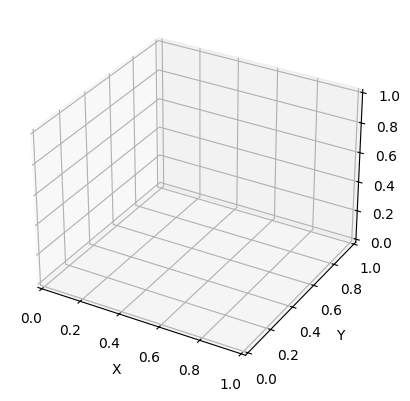

In [ ]:
def create_foundation_materials(k_trans, k_rot) -> Tuple[int, ...]:
    mats = [next_material_tag() for _ in range(6)]
    ops.uniaxialMaterial('Elastic', mats[0], k_trans[0])
    ops.uniaxialMaterial('Elastic', mats[1], k_trans[1])
    ops.uniaxialMaterial('Elastic', mats[2], k_trans[2])
    ops.uniaxialMaterial('Elastic', mats[3], k_rot[0])
    ops.uniaxialMaterial('Elastic', mats[4], k_rot[1])
    ops.uniaxialMaterial('Elastic', mats[5], k_rot[2])
    return tuple(mats)


def set_foundation_linear_springs_min(
    pier_nodes,
    mat_tags: Tuple[int, ...],
    ele_tag_base: int,
    node_counter: Dict[str, int]
):
    ele_tag = int(ele_tag_base)

    results = {
        "spring_nodes": [],
        "ground_nodes": [],
        "elements": []
    }

    def _next_node_tag():
        tag = node_counter["value"]
        node_counter["value"] += 1
        return tag

    for span in pier_nodes:
        for col_nodes in span:
            base_node = int(col_nodes[0])
            x, y, z = ops.nodeCoord(base_node)

            spring_node = _next_node_tag()
            ops.node(spring_node, x, y, z)
            ops.equalDOF(spring_node, base_node, 1, 2, 3, 4, 5, 6)

            ground_node = _next_node_tag()
            ops.node(ground_node, x, y, z)
            ops.fix(ground_node, 1, 1, 1, 1, 1, 1)

            ops.element('zeroLength', ele_tag, spring_node, ground_node,
                        '-mat', *mat_tags,
                        '-dir', 1, 2, 3, 4, 5, 6)

            results["spring_nodes"].append(spring_node)
            results["ground_nodes"].append(ground_node)
            results["elements"].append(ele_tag)
            ele_tag += 1

    return results


### 桥墩支座


In [38]:
def define_bearing_materials(design: BearingDesign = BEARING_DESIGN) -> Tuple[int, int, int, int]:
    mat_fx = next_material_tag()
    mat_fy = next_material_tag()
    mat_fz = next_material_tag()
    mat_rot = next_material_tag()
    ops.uniaxialMaterial('Steel01', mat_fx, design.bfy, design.bkh1, 0.0)
    ops.uniaxialMaterial('Steel01', mat_fy, design.bfy, design.bkh2, 0.0)
    ops.uniaxialMaterial('Elastic', mat_fz, design.bkh3)
    ops.uniaxialMaterial('Elastic', mat_rot, design.rot_stiff)
    return mat_fx, mat_fy, mat_fz, mat_rot


def build_bearings(deck_nodes,
                   capbeam_nodes,
                   node_counter: Dict[str, int],
                   design: BearingDesign = BEARING_DESIGN,
                   ele_tag_start: int = 6000):
    """
    参照 Tcl：在主梁下方生成支座节点，与盖梁节点之间布置 6 自由度 zeroLength。
    """
    mat_fx, mat_fy, mat_fz, mat_rot = define_bearing_materials(design)

    deck_tags = [dn for row in deck_nodes for dn in row]
    deck_x = {dn: ops.nodeCoord(dn)[0] for dn in deck_tags}

    def _next_node_tag():
        tag = node_counter["value"]
        node_counter["value"] += 1
        return tag

    def _nearest_deck_node(x_target: float) -> int:
        return min(deck_tags, key=lambda dn: abs(deck_x[dn] - x_target))

    ele = int(ele_tag_start)
    bearing_elements = []
    bearing_pairs = []

    for pier_cap_nodes in capbeam_nodes:
        # 保留盖梁节点的完整坐标，便于严格对齐原 Tcl 模型的支座布置
        cap_coords = {tag: ops.nodeCoord(tag) for tag in pier_cap_nodes}
        x_center = cap_coords[pier_cap_nodes[0]][0]
        deck_master = _nearest_deck_node(x_center)

        for y_offset in design.positions:
            top_node = _next_node_tag()
            cap_target = min(pier_cap_nodes, key=lambda tag: abs(cap_coords[tag][1] - y_offset))
            _, _, z_cap = cap_coords[cap_target]
            ops.node(top_node, x_center, y_offset, z_cap)
            ops.rigidLink('beam', deck_master, top_node)

            ops.element('zeroLength', ele, top_node, cap_target,
                        '-mat', mat_fx, mat_fy, mat_fz, mat_rot, mat_rot, mat_rot,
                        '-dir', 1, 2, 3, 4, 5, 6)

            bearing_elements.append(ele)
            bearing_pairs.append((top_node, cap_target))
            ele += 1

    return {
        "bearing_eles": bearing_elements,
        "pairs": bearing_pairs,
        "mat_tags": (mat_fx, mat_fy, mat_fz, mat_rot)
    }
# opsvis.plot_model(show_node_numbering=True)


### 桥台


In [39]:

def set_abutment(
    deck_nodes,
    start_node_tag,
    start_ele_tag,
    ssi_mat_tags, ssi_dirs,          # 桥台-地基：土弹簧
    bearing_mat_tags, bearing_dirs,  # 主梁-桥台：支座
    contact_mat_tags, contact_dirs,  # 主梁-桥台：碰撞/限位
    shearkey_mat_tags, shearkey_dirs,# 主梁-桥台：剪力键
    x_tol=1e-9
):
    # 识别首尾主梁节点：x最小和x最大；若同x取|y|最小
    tags = [n for row in deck_nodes for n in row]
    xyz  = {n: ops.nodeCoord(n) for n in tags}
    left  = min(tags, key=lambda n: (xyz[n][0],  abs(xyz[n][1])))
    right = max(tags, key=lambda n: (xyz[n][0], -abs(xyz[n][1])))


    tnode = int(start_node_tag)
    tele  = int(start_ele_tag)

    res = {
        "deck_end_nodes": {"left": left, "right": right},
        "abutment_nodes": {},     # 桥台节点
        "foundation_nodes": {},   # 地基节点
        "ssi_elements": [],       # 桥台-地基
        "bearing_elements": [],   # 主梁-桥台 支座
        "contact_elements": [],   # 主梁-桥台 碰撞
        "shearkey_elements": []   # 主梁-桥台 剪力键
    }

    for side, dn in (("left", left), ("right", right)):
        x, y, z = xyz[dn]

        abut = tnode; tnode += 1
        base = tnode; tnode += 1
        ops.node(abut, x, y, z)
        ops.node(base, x, y, z)
        ops.fix(base, 1, 1, 1, 1, 1, 1)

        # 桥台-地基：SSI
        ops.element('zeroLength', tele, abut, base,
                    '-mat', *ssi_mat_tags, '-dir', *ssi_dirs)
        res["ssi_elements"].append(tele); tele += 1

        # 主梁-桥台：支座
        ops.element('zeroLength', tele, dn, abut,
                    '-mat', *bearing_mat_tags, '-dir', *bearing_dirs)
        res["bearing_elements"].append(tele); tele += 1

        # 主梁-桥台：碰撞/限位
        ops.element('zeroLength', tele, dn, abut,
                    '-mat', *contact_mat_tags, '-dir', *contact_dirs)
        res["contact_elements"].append(tele); tele += 1

        # 主梁-桥台：剪力键
        ops.element('zeroLength', tele, dn, abut,
                    '-mat', *shearkey_mat_tags, '-dir', *shearkey_dirs)
        res["shearkey_elements"].append(tele); tele += 1

        res["abutment_nodes"][side] = abut
        res["foundation_nodes"][side] = base

    return res


## 重力与分析前处理


In [40]:
def apply_uniform_gravity_loads(pier_elements: List[int],
                                cap_elements: List[int],
                                girder_elements: List[int],
                                pier_weight: float,
                                cap_weight: float,
                                girder_weight: float,
                                ts_tag: int = 1,
                                pat_tag: int = 1):
    """
    参照 Tcl：通过 eleLoad -beamUniform 对不同构件施加自重。
    """
    ops.wipeAnalysis()
    ops.timeSeries('Linear', ts_tag)
    ops.pattern('Plain', pat_tag, ts_tag)

    for e in pier_elements:
        ops.eleLoad('-ele', e, '-type', '-beamUniform', 0.0, 0.0, -pier_weight)

    for e in cap_elements:
        ops.eleLoad('-ele', e, '-type', '-beamUniform', 0.0, -cap_weight, 0.0)

    for e in girder_elements:
        ops.eleLoad('-ele', e, '-type', '-beamUniform', 0.0, -girder_weight, 0.0)

    ops.constraints("Transformation")
    ops.numberer("RCM")
    ops.system("BandGeneral")
    ops.test("NormDispIncr", 1.0e-6, 50)
    ops.algorithm("Newton")
    ops.integrator("LoadControl", 0.1)
    ops.analysis("Static")
    status = ops.analyze(10)
    ops.loadConst('-time', 0.0)
    return status


## 设置阻尼


In [41]:
# 计算自振周期与设置 Rayleigh 阻尼
def get_periods(nMode=3):
    ops.wipeAnalysis()
    ops.system('BandGeneral')
    ops.numberer('RCM')
    ops.constraints('Transformation')
    lambdas = ops.eigen(nMode)
    periods = []
    for lam in lambdas:
        if lam is None or lam <= 0.0:
            periods.append(None)
        else:
            omega = math.sqrt(lam)
            periods.append(2.0 * math.pi / omega)
    return periods

def set_rayleigh_damping_by_T(T1, T2, xi):
    w1 = 2.0 * math.pi / T1
    w2 = 2.0 * math.pi / T2
    alphaM = 2.0 * xi * w1 * w2 / (w1 + w2)
    betaK = 2.0 * xi / (w1 + w2)
    ops.rayleigh(alphaM, 0.0, betaK, 0.0)
    return alphaM, betaK

def configure_default_rayleigh(xi=0.05, nMode=6):
    # 多求几个振型，防止前面有刚体模态
    Ts = get_periods(nMode)

    # 只保留真正有意义的周期
    valid_T = [T for T in Ts if (T is not None) and (T > 0.0)]

    if len(valid_T) < 2:
        raise RuntimeError('振型中有效周期不足 2 个，无法设置 Rayleigh 阻尼')

    T1, T2 = valid_T[0], valid_T[1]

    w1 = 2.0 * math.pi / T1
    w2 = 2.0 * math.pi / T2
    alphaM = 2.0 * xi * w1 * w2 / (w1 + w2)
    betaK  = 2.0 * xi / (w1 + w2)
    ops.rayleigh(alphaM, 0.0, betaK, 0.0)
    print(f"Rayleigh damping applied with T1={T1:.3f}s, T2={T2:.3f}s, xi={xi}")
    return {"periods": Ts, "alphaM": alphaM, "betaK": betaK}


# 重建整个桥梁模型并完成重力分析，返回关键节点/单元信息。


In [42]:
def rebuild_model_with_gravity():
    """重建整个桥梁模型并完成重力分析，返回关键节点/单元信息。"""
    ops.wipe()
    ops.model('basic', '-ndm', 3, '-ndf', 6)
    units = {"length": "m", "force": "N", "mass": "kg"}

    pier_res = define_pier_nodes(num_spans=num_spans,
                                 span_length=span_length,
                                 cols_per_pier=cols_per_pier,
                                 nodes_per_col=nodes_per_col,
                                 col_height=col_height,
                                 deck_width=deck_width,
                                 edge_clear=edge_clear)

    deck_res = define_deck_nodes(num_spans=num_spans,
                                 span_length=span_length,
                                 nodes_per_span=nodes_per_span,
                                 col_height=col_height,
                                 capbeam_depth=CAPBEAM_DESIGN.depth,
                                 bearing_height=0.1,
                                 girder_centroid_height=1.24)

    capbeam_res = define_capbeam_nodes(pier_res["pier_nodes"])
    node_counter = init_node_counter(capbeam_res["next_tag"])

    pier_section = define_pier_section()
    cap_section = define_capbeam_section()
    misc_mats = define_misc_materials()

    pier_ele = build_pier_elements_nonlin(
        pier_nodes=pier_res["pier_nodes"],
        secTag=pier_section["sec_tag"],
        ele_tag_start=1,
        np=10,
        mass_per_length=pier_section["mass_per_length"]
    )

    girder_G = GIRDER_DESIGN.E / (2.0 * (1.0 + GIRDER_DESIGN.nu))
    beam_ele = build_beam_elements_elastic(
        deck_nodes=deck_res["deck_nodes"],
        A=GIRDER_DESIGN.A,
        E=GIRDER_DESIGN.E,
        G=girder_G,
        J=GIRDER_DESIGN.J,
        Iy=GIRDER_DESIGN.Iy,
        Iz=GIRDER_DESIGN.Iz,
        ele_tag_start=1000,
        mass_per_length=GIRDER_DESIGN.mass_per_length
    )

    cap_ele = build_capbeam_elements(
        capbeam_nodes=capbeam_res["capbeam_nodes"],
        secTag=cap_section["sec_tag"],
        mass_per_length=cap_section["mass_per_length"],
        ele_tag_start=2000
    )

    tie_piers_to_cap_nodes(pier_res["pier_nodes"], capbeam_res["capbeam_nodes"])

    k_trans = (4.21875e7, 2.109375e7, 7.5e9)
    k_rot = (4.5e8, 2.25e8, 1.2e8)
    foundation_mats = create_foundation_materials(k_trans, k_rot)
    foundation_res = set_foundation_linear_springs_min(
        pier_nodes=pier_res["pier_nodes"],
        mat_tags=foundation_mats,
        ele_tag_base=1500,
        node_counter=node_counter
    )

    bear_res = build_bearings(deck_res["deck_nodes"], capbeam_res["capbeam_nodes"], node_counter)

    abutment_res = set_abutment(deck_nodes=deck_res["deck_nodes"],
                                start_node_tag=node_counter["value"],
                                start_ele_tag=8000,
                                ssi_mat_tags=(misc_mats["soil"],), ssi_dirs=(1,),
                                bearing_mat_tags=bear_res["mat_tags"][:3], bearing_dirs=(1, 2, 3),
                                contact_mat_tags=(misc_mats["deck_abut"],), contact_dirs=(1,),
                                shearkey_mat_tags=(misc_mats["shear_key"],), shearkey_dirs=(2,),
                                x_tol=1e-9)
    for abut_tag in abutment_res["abutment_nodes"].values():
        ops.fix(abut_tag, 0, 0, 0, 1, 1, 1)

    pier_weight = pier_section["mass_per_length"] * G
    cap_weight = cap_section["mass_per_length"] * G
    girder_weight = GIRDER_DESIGN.mass_per_length * G

    status = apply_uniform_gravity_loads(pier_ele, cap_ele, beam_ele,
                                         pier_weight, cap_weight, girder_weight)
    if status != 0:
        raise RuntimeError(f'重力分析失败')

    damping_info = configure_default_rayleigh()

    return {
        "pier_res": pier_res,
        "deck_res": deck_res,
        "capbeam_res": capbeam_res,
        "bear_res": bear_res,
        "cap_ele": cap_ele,
        "foundation": foundation_res,
        "abutment_res": abutment_res,
        "pier_ele": pier_ele,
        "beam_ele": beam_ele,
        "units": units,
        "damping": damping_info
    }


In [43]:
import numpy as np
from pathlib import Path

def apply_uniform_gm_from_txt(file_path, ts_tag=200, pattern_tag=200, dof=1, factor=9.8):
    """
    从 txt 文件加载地震动并建立 Path timeSeries + UniformExcitation。
    返回包含时间序列信息的字典，便于确定积分步长。
    """
    data = np.loadtxt(file_path)
    t = np.array(data[:, 0], dtype=float)
    acc = np.array(data[:, 1], dtype=float) * float(factor)

    # 时间轴归一到从 0 开始
    if t[0] != 0.0:
        t = t - t[0]

    # 总时长（秒）
    tFinal = float(t[-1])

    ops.timeSeries('Path', ts_tag,
                   '-time', *t.tolist(),
                   '-values', *acc.tolist())
    ops.pattern('UniformExcitation', pattern_tag, dof,
                '-accel', ts_tag)

    return {"time": t, "acc": acc, "tFinal": tFinal}


## 执行分析


In [44]:
def setup_default_recorders(output_dir, pier_res, bear_res, abutment_res):
    """按既定节点/单元记录响应，输出到指定文件夹。"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    pier_nodes_to_rec = [
        pier_res["pier_nodes"][i][j][-1]
        for i in range(len(pier_res["pier_nodes"]))
        for j in range(len(pier_res["pier_nodes"][i]))
    ]
    bearing_deck_nodes = [pair[0] for pair in bear_res["pairs"]]
    bearing_cap_nodes = [pair[1] for pair in bear_res["pairs"]]
    bearing_eles = bear_res["bearing_eles"]
    abutment_nodes_to_rec = [
        abutment_res["abutment_nodes"]["left"],
        abutment_res["abutment_nodes"]["right"]
    ]

    ops.remove('recorders')

    ops.recorder('Node',
                 '-file', str(output_dir / 'rec_pier_top_disp.out'),
                 '-time',
                 '-node', *pier_nodes_to_rec,
                 '-dof', 1, 2, 3,
                 'disp')

    ops.recorder('Node',
                 '-file', str(output_dir / 'rec_bearing_cap_disp.out'),
                 '-time',
                 '-node', *bearing_cap_nodes,
                 '-dof', 1, 2, 3,
                 'disp')

    ops.recorder('Node',
                 '-file', str(output_dir / 'rec_bearing_deck_disp.out'),
                 '-time',
                 '-node', *bearing_deck_nodes,
                 '-dof', 1, 2, 3,
                 'disp')

    ops.recorder('Element',
                 '-file', str(output_dir / 'rec_bearing_def.out'),
                 '-time',
                 '-ele', *bearing_eles,
                 'deformations')

    ops.recorder('Node',
                 '-file', str(output_dir / 'rec_abutment_disp.out'),
                 '-time',
                 '-node', *abutment_nodes_to_rec,
                 '-dof', 1, 2, 3,
                 'disp')


In [ ]:
import csv
import shutil
def run_ground_motion_batch(gm_root, results_root=Path('results'), factor=9.8):
    gm_root = Path(gm_root)
    results_root = Path(results_root)

    # 清空结果目录
    if results_root.exists():
        for item in results_root.iterdir():
            if item.is_file():
                item.unlink()
            elif item.is_dir():
                shutil.rmtree(item)
    results_root.mkdir(parents=True, exist_ok=True)

    pga_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    summary = []

    for pga in pga_values:
        pga_folder_name = f"PGA_{pga:.2f}g"
        pga_path = gm_root / pga_folder_name
        if not pga_path.exists():
            print(f"警告: 找不到 {pga_folder_name} 文件夹，跳过。")
            continue
            
        h1_folder = pga_path / "H1"
        h2_folder = pga_path / "H2"
        
        h1_files = sorted(h1_folder.glob('*.txt'))
        h2_files = sorted(h2_folder.glob('*.txt'))
        
            
        # 创建 PGA 结果子目录
        pga_result_dir = results_root / pga_folder_name
        pga_result_dir.mkdir(parents=True, exist_ok=True)

        for idx, (h1_file, h2_file) in enumerate(zip(h1_files, h2_files), start=1):
            # 使用 H1 文件名作为记录名 (去除 .txt)
            record_name = h1_file.stem
            print(f"[{pga_folder_name}] [{idx}/{len(h1_files)}] 处理 {record_name}")
            
            gm_tag_h1 = 2000 + idx * 2
            gm_tag_h2 = 2000 + idx * 2 + 1
            
            run_info = {
                'pga': pga,
                'record_name': record_name,
                'status': 'pending',
                'steps_completed': 0,
                'message': ''
            }

            try:
                model_ctx = rebuild_model_with_gravity()
                
                # 应用 H1 到 DOF 1 (X方向)
                gm_info_h1 = apply_uniform_gm_from_txt(
                    str(h1_file),
                    ts_tag=gm_tag_h1,
                    pattern_tag=gm_tag_h1,
                    dof=1,
                    factor=factor
                )
                
                # 应用 H2 到 DOF 2 (Y方向)
                gm_info_h2 = apply_uniform_gm_from_txt(
                    str(h2_file),
                    ts_tag=gm_tag_h2,
                    pattern_tag=gm_tag_h2,
                    dof=2,
                    factor=factor
                )

                out_dir = pga_result_dir / record_name
                setup_default_recorders(
                    out_dir,
                    model_ctx['pier_res'],
                    model_ctx['bear_res'],
                    model_ctx['abutment_res']
                )

                ops.wipeAnalysis()
                ops.constraints('Transformation')
                ops.numberer('RCM')
                ops.system('BandGeneral')

                # 全局收敛标准稍微放宽一点，给非线性留点空间
                ops.test('NormDispIncr', 1.0e-4, 50)
                ops.algorithm('NewtonLineSearch', '-type', 'Bisection')
                ops.integrator('Newmark', 0.5, 0.25)
                ops.analysis('Transient')

                # 使用两个地震波中较长的时间
                tFinal = max(gm_info_h1['tFinal'], gm_info_h2['tFinal'])
                base_dt = 0.002      # 你原来的时间步
                dt_min  = 0.00025    # 最小允许时间步
                t_now   = 0.0
                step_ok = 0
                ok      = 0

                while t_now < tFinal:
                    ok = ops.analyze(1, base_dt)
                    if ok == 0:
                        # 正常通过这一小步
                        t_now += base_dt
                        step_ok += 1
                        continue

                    # 如果这一小步不收敛，自动把步长减半重试
                    dt_try = base_dt / 2.0
                    retry_ok = 0
                    while dt_try >= dt_min:
                        retry_ok = ops.analyze(1, dt_try)
                        if retry_ok == 0:
                            t_now += dt_try
                            step_ok += 1
                            break
                        dt_try /= 2.0

                    if retry_ok != 0:
                        # 缩到 dt_min 还是过不去，就认为在这一时刻结构已经
                        # 深入到求解器控制不了的状态，提前退出
                        ok = -3
                        break
                
                if ok == 0:
                    run_info['status'] = 'success'
                    run_info['steps_completed'] = step_ok
                else:
                    run_info['status'] = 'failed'
                    run_info['message'] = f'Analysis failed at t={t_now:.3f}'


            except Exception as exc:
                run_info['status'] = 'error'
                run_info['message'] = str(exc)

            finally:
                # 统一清理，不管成功还是异常
                try:
                    ops.remove('recorders')
                    ops.remove('loadPattern', gm_tag_h1)
                    ops.remove('timeSeries', gm_tag_h1)
                    ops.remove('loadPattern', gm_tag_h2)
                    ops.remove('timeSeries', gm_tag_h2)
                except Exception:
                    pass

            summary.append(run_info)

    summary_file = results_root / 'batch_summary.csv'
    with summary_file.open('w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(
            f,
            fieldnames=['pga', 'record_name', 'status', 'steps_completed', 'message']
        )
        writer.writeheader()
        writer.writerows(summary)

    return summary


GM_DIR = Path("GM/ground_motions/processed")
RESULT_ROOT = Path('results')
batch_summary = run_ground_motion_batch(GM_DIR, RESULT_ROOT, factor=9.8)
print('Batch summary写入:', RESULT_ROOT / 'batch_summary.csv')

[PGA_0.50g] [1/30] 处理 RSN1044_NORTHR_NWH360
Rayleigh damping applied with T1=1.460s, T2=1.318s, xi=0.05
[PGA_0.50g] [2/30] 处理 RSN1045_NORTHR_WPI046
Rayleigh damping applied with T1=1.460s, T2=1.318s, xi=0.05
[PGA_0.50g] [3/30] 处理 RSN1048_NORTHR_STC180
Rayleigh damping applied with T1=1.460s, T2=1.318s, xi=0.05
[PGA_0.50g] [4/30] 处理 RSN1158_KOCAELI_DZC270
Rayleigh damping applied with T1=1.460s, T2=1.318s, xi=0.05
[PGA_0.50g] [5/30] 处理 RSN1176_KOCAELI_YPT150
Rayleigh damping applied with T1=1.460s, T2=1.318s, xi=0.05
[PGA_0.50g] [6/30] 处理 RSN1194_CHICHI_CHY025-E
Rayleigh damping applied with T1=1.460s, T2=1.318s, xi=0.05
[PGA_0.50g] [7/30] 处理 RSN1481_CHICHI_TCU038-E
Rayleigh damping applied with T1=1.460s, T2=1.318s, xi=0.05
[PGA_0.50g] [8/30] 处理 RSN1498_CHICHI_TCU059-N
Rayleigh damping applied with T1=1.460s, T2=1.318s, xi=0.05
[PGA_0.50g] [9/30] 处理 RSN1602_DUZCE_BOL090
Rayleigh damping applied with T1=1.460s, T2=1.318s, xi=0.05
[PGA_0.50g] [10/30] 处理 RSN1605_DUZCE_DZC270
Rayleigh damp